In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Patch
import matplotlib
import pandas as pd
import pathlib
import math

from utils import model_shortname

# remove limits for rows and cols in dataframe listing
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

Using TensorFlow backend.
/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


In [11]:
# parser = argparse.ArgumentParser(description='Create barplots for a given dataset')
# parser.add_argument("-d", "--dataset", type=str, default="/misc/users/tiagonb/covid-net/dataset/NCP/88/1310", help="path to images")
# parser.add_argument("-o", "--output", type=str, default="", help="save to output file")
# parser.add_argument("-t", "--figtitle", type=str, default="", help="title of the figure")
# args = vars(parser.parse_args())

# dataset_name = '/misc/users/tiagonb/covid-net/dataset/NCP/3976/5484'
# dataset_name = '/misc/users/tiagonb/covid-net/dataset/CP/1447/3967'
dataset_name = '/misc/users/tiagonb/covid-net/dataset/Normal/1727/1012'
suptitle = 'Normal exam'
savefig = 'barplot_Normal_1727_1012'
# dataset_name = args['dataset']
# suptitle = args['figtitle']
# savefig = args['output']

In [3]:
# lesions_slices used to mark which slices were confirmed a lesion
lesion_file = '/misc/users/tiagonb/covid-net/dataset/lesions_slices.csv'
lesion_data = pd.read_csv(lesion_file)
lesion_data['lesion_key'] = lesion_data['imgpath'].str.split(
    '/').str[-4:].str.join("/").str.split('.').str[-2]

In [4]:
# loading predictions from feather file (processed in another notebook)
p = pathlib.Path("./predictions.feather")
if p.is_file():
    df = pd.read_feather(p)
else:
    df = pd.DataFrame()

In [5]:
# process strings from feather file and include in the dataframe to help analysis
df['lesion_key'] = df['files'].str.split(
    '/').str[-4:].str.join("/").str.split('.').str[-2]
df['data_class'] = df['dataset'].str.split('/').str[-3]
df['patient_id'] = df['dataset'].str.split('/').str[-2]
df['scan_id'] = df['dataset'].str.split('/').str[-1]
df = pd.merge(df, lesion_data, how="left")
print("imagens without lesion confirmation: ", len(df[df['imgpath'].isnull()]))
# vector mark which image is in lesion file
df['has_lesion'] = df['imgpath'].notnull()
df.drop(['lesion_key', 'imgpath'], axis=1, inplace=True)

imagens without lesion confirmation:  17420


In [6]:
# loading predictions from feather file (processed in another notebook)
p = pathlib.Path("./predictions_clusters.feather")
if p.is_file():
    df_c = pd.read_feather(p)
else:
    df_c = pd.DataFrame()
df = pd.merge(df, df_c, how="left")

In [7]:
df = df[df['dataset'] == dataset_name]
models = df['model'].unique()

In [8]:
df.head()

model  \
9347  /misc/users/tiagonb/covid-net/source/COVIDNet-CT/models/COVIDNet-CT-A   
9348  /misc/users/tiagonb/covid-net/source/COVIDNet-CT/models/COVIDNet-CT-A   
9349  /misc/users/tiagonb/covid-net/source/COVIDNet-CT/models/COVIDNet-CT-A   
9350  /misc/users/tiagonb/covid-net/source/COVIDNet-CT/models/COVIDNet-CT-A   
9351  /misc/users/tiagonb/covid-net/source/COVIDNet-CT/models/COVIDNet-CT-A   

                                                  dataset  \
9347  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607   
9348  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607   
9349  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607   
9350  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607   
9351  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607   

                                                             files   prob_CP  \
9347  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607/0254.jpg  0.978574   
9348  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607/0429.jpg  0.002847   
9349  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607/0049.jpg  0.519249   
9350  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607/0280.jpg  0.987514   
9351  /misc/users/tiagonb/covid-net/dataset/NCP/1036/2607/0111.jpg  0.001659   

      prob_NCP  prob_Normal pred_class data_class patient_id scan_id  \
9347  0.020805  0.000622     CP         NCP        1036       2607     
9348  0.972320  0.024833     NCP        NCP        1036       2607     
9349  0.001877  0.478873     CP         NCP        1036       2607     
9350  0.012034  0.000452     CP         NCP        1036       2607     
9351  0.000610  0.997731     Normal     NCP        1036       2607     

      has_lesion  prob_suplung   prob_badimg  prob_midlung  prob_influng  \
9347  False       4.004505e-10  3.461602e-09  0.999999      1.428124e-06   
9348  True        9.977390e-06  9.690667e-07  0.000289      9.996998e-01   
9349  False       9.997881e-01  5.831442e-06  0.000041      1.651338e-04   
9350  False       2.132374e-12  2.339578e-10  1.000000      9.577054e-09   
9351  False       9.821634e-01  5.977696e-06  0.017808      2.254916e-05   

     pred_lungclass  
9347  middle_lung    
9348  inferior_lung  
9349  superior_lung  
9350  middle_lung    
9351  superior_lung

In [12]:
# loading predictions from feather file (processed in another notebook)
p = pathlib.Path("./predictions_all_info.feather")
if p.is_file():
    df = pd.read_feather(p)
else:
    df = pd.DataFrame()

df = df[df['dataset'] == dataset_name]
models = df['model'].unique()
models = ['/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S',
          '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_L',
          '/misc/users/tiagonb/covid-net/tools/experiments/mlruns/6/a2e0cca363864022bb95d29362abea83/artifacts/model/data/model.h5',
          '/misc/users/tiagonb/covid-net/tools/experiments/mlruns/6/da94eba6fec04c908d77f33ea7f1f405/artifacts/model/data/model.h5',
          ]

n=4, cols=12, rows=1


/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/tiagonb/miniconda2/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The Post

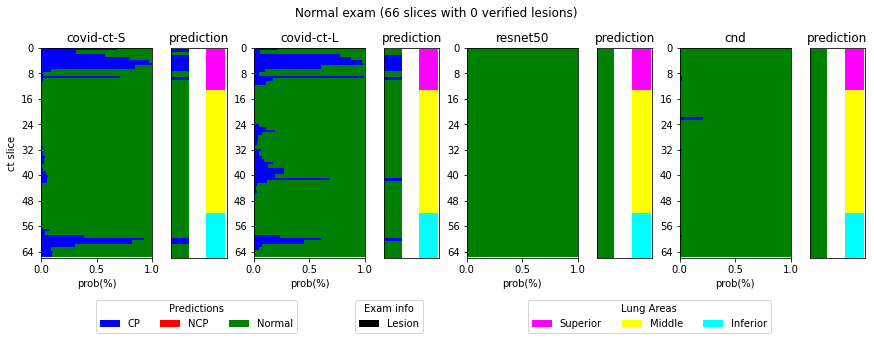

In [13]:
# defining number of columns and rows in the matplotlib fig, each graph ocupy 3 columns
n = len(models)
num_columns = 12
columns_for_graph = 3
num_rows = math.ceil(n / (num_columns // columns_for_graph))
print('n={}, cols={}, rows={}'.format(n, num_columns, num_rows))
fig = plt.figure(constrained_layout=True, figsize=(num_columns, num_rows*4))
spec = fig.add_gridspec(num_rows, num_columns)
if suptitle:
    fig.suptitle(suptitle)

# create grid specifications
axs = []
for g in range(n):
    floor_div = g // (num_columns // columns_for_graph)
    re_div = g % (num_columns // columns_for_graph)
    i, j = floor_div, re_div * columns_for_graph
    ax1 = fig.add_subplot(spec[i, (j):(j+2)])
    ax2 = fig.add_subplot(spec[i, (j+2):(j+3)])
    axs.append((ax1, ax2))

# iterate in each model
for i, m in enumerate(models):
    model_data = df[df['model'] == m].sort_values(
        by=['files'], ascending=True).reset_index(drop=True)
    len_data = len(model_data.index)
    n_lesions = model_data['has_lesion'].sum()
    model_data['pred_dummy'] = [0.33] * len_data
    model_data['lesion_dummy'] = [0.33] * len_data
    model_data['cluster_dummy'] = [0.33] * len_data
    fig.suptitle("{} ({} slices with {} verified lesions)".format(
        suptitle, len_data, n_lesions))

    # recover previus created axes
    ax = axs[i]
    ax1, ax2 = ax[0], ax[1]

    classes_order = (['NCP'] * len_data) + (['CP'] *
                                            len_data) + (['Normal'] * len_data)

    # add width=1.0 to remove space between bars
    barplot1 = model_data[['prob_NCP', 'prob_CP', 'prob_Normal']].plot(kind='barh',
                                                                            stacked=True,
                                                                            legend=False,
                                                                            ax=ax1, width=1.0)
    # change patches colors
    children1 = barplot1.get_children()
    barlist1 = filter(lambda x: isinstance(
        x, matplotlib.patches.Rectangle), children1)
    for c, bar in zip(classes_order, barlist1):
        if c == "CP":
            bar.set_color('blue')
        elif c == "NCP":
            bar.set_color('red')
        else:
            bar.set_color('green')

    # concatenate values in one big vector to help set the correct color afterward
    data_type = ([0]*len_data) + ([1]*len_data) + ([2]*len_data)
    pred_n_lessions = pd.concat([model_data['pred_class'],
                                 model_data['has_lesion'],
                                 model_data['pred_lungclass']]).reset_index(drop=True)

    # add width=1.0 to remove space between bars
    barplot2 = model_data[['pred_dummy', 'lesion_dummy', 'cluster_dummy']].plot(kind='barh',
                                                                                stacked=True,
                                                                                legend=False,
                                                                                ax=ax2, width=1.0)
    # change patches colors
    children2 = barplot2.get_children()
    barlist2 = filter(lambda x: isinstance(
        x, matplotlib.patches.Rectangle), children2)
    for c, dt, bar in zip(pred_n_lessions, data_type, barlist2):
        if dt == 0:
            if c == "CP":
                bar.set_color('blue')
            elif c == "NCP":
                bar.set_color('red')
            else:
                bar.set_color('green')
        elif dt == 1:
            if c:
                bar.set_color('black')
            else:
                bar.set_color('white')
        else:
            if c == "superior_lung":
                bar.set_color('magenta')
            elif c == "middle_lung":
                bar.set_color('yellow')
            elif c == "inferior_lung":
                bar.set_color('cyan')
            else:
                bar.set_color('black')

    # adjusting graph
    if not i % n:
        ax1.set_ylabel("ct slice")
    ax1.set_xlabel("prob(%)")
    ax1.set_ylim(0, len_data)
    ax1.invert_yaxis()
    ax1.set_xlim(0.0, 1)
    try:
        short_name = model_shortname[m]
    except:
        short_name = "no name"
    ax1.set_title(short_name)
    ax1.yaxis.set_major_locator(plticker.MaxNLocator(integer=True))
    ax1.yaxis.set_major_formatter(plticker.ScalarFormatter())
    ax2.set_xticks([], [])
    ax2.set_yticks([], [])
    ax2.invert_yaxis()
    ax2.set_title("prediction")

# custom legend for the graph
legend_elements1 = [Patch(facecolor='blue', label='CP'),
                    Patch(facecolor='red', label='NCP'),
                    Patch(facecolor='green', label='Normal')]
fig.legend(handles=legend_elements1, loc='upper left',
           title="Predictions", bbox_to_anchor=(0.10, -0.01), ncol=3)
legend_elements2 = [Patch(facecolor='black', label='Lesion')]
fig.legend(handles=legend_elements2, loc='upper left',
           title="Exam info", bbox_to_anchor=(0.40, -0.01), ncol=1)
legend_elements3 = [Patch(facecolor='magenta', label='Superior'),
                    Patch(facecolor='yellow', label='Middle'),
                    Patch(facecolor='cyan', label='Inferior')]
fig.legend(handles=legend_elements3, loc='upper left',
           title="Lung Areas", bbox_to_anchor=(0.60, -0.01), ncol=3)


if savefig:
    plt.savefig(savefig, facecolor='white', transparent=False,
                format='eps', bbox_inches='tight')